In [1]:
import numpy as np
import phate
import leidenalg
import scprep, scanpy

In [17]:
adata = scanpy.read_h5ad('./data/skin_processed_human_name.h5ad')
adata.obs['samples'] = [x[:-2] for x in adata.obs.sample_labels]

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
hvgs = np.array(adata[:, adata.var.hvg].var.symbol)

In [ ]:
phate_op = phate.PHATE(random_state=42, knn=40, decay=10, use_pygsp=True)
phate_op.fit(adata.obsm['X_PCA'])

# GSPA operator constructs wavelet dictionary
gspa_op = gspa.GSPA(graph=phate_op.graph)
gspa_op.build_diffusion_operator()
gspa_op.build_wavelet_dictionary()

# Embed gene signals from wavelet dictionary
gene_signals =  adata[:, adata.var.hvg].to_df().T # embed all highly variable genes
gene_ae, gene_pc = gspa_op.get_gene_embeddings(gene_signals)
res = {}
for cell_type in ['epithelial', 'tcells', 'myeloid', 'fibroblasts']:
    res[f'{cell_type}_association'] = gspa_op.calculate_cell_type_specificity(adata.obs['cell_types'], cell_type)

In [ ]:
gene_phate_op = phate.PHATE(random_state=42)
gene_phate = gene_phate_op.fit_transform(gene_ae)

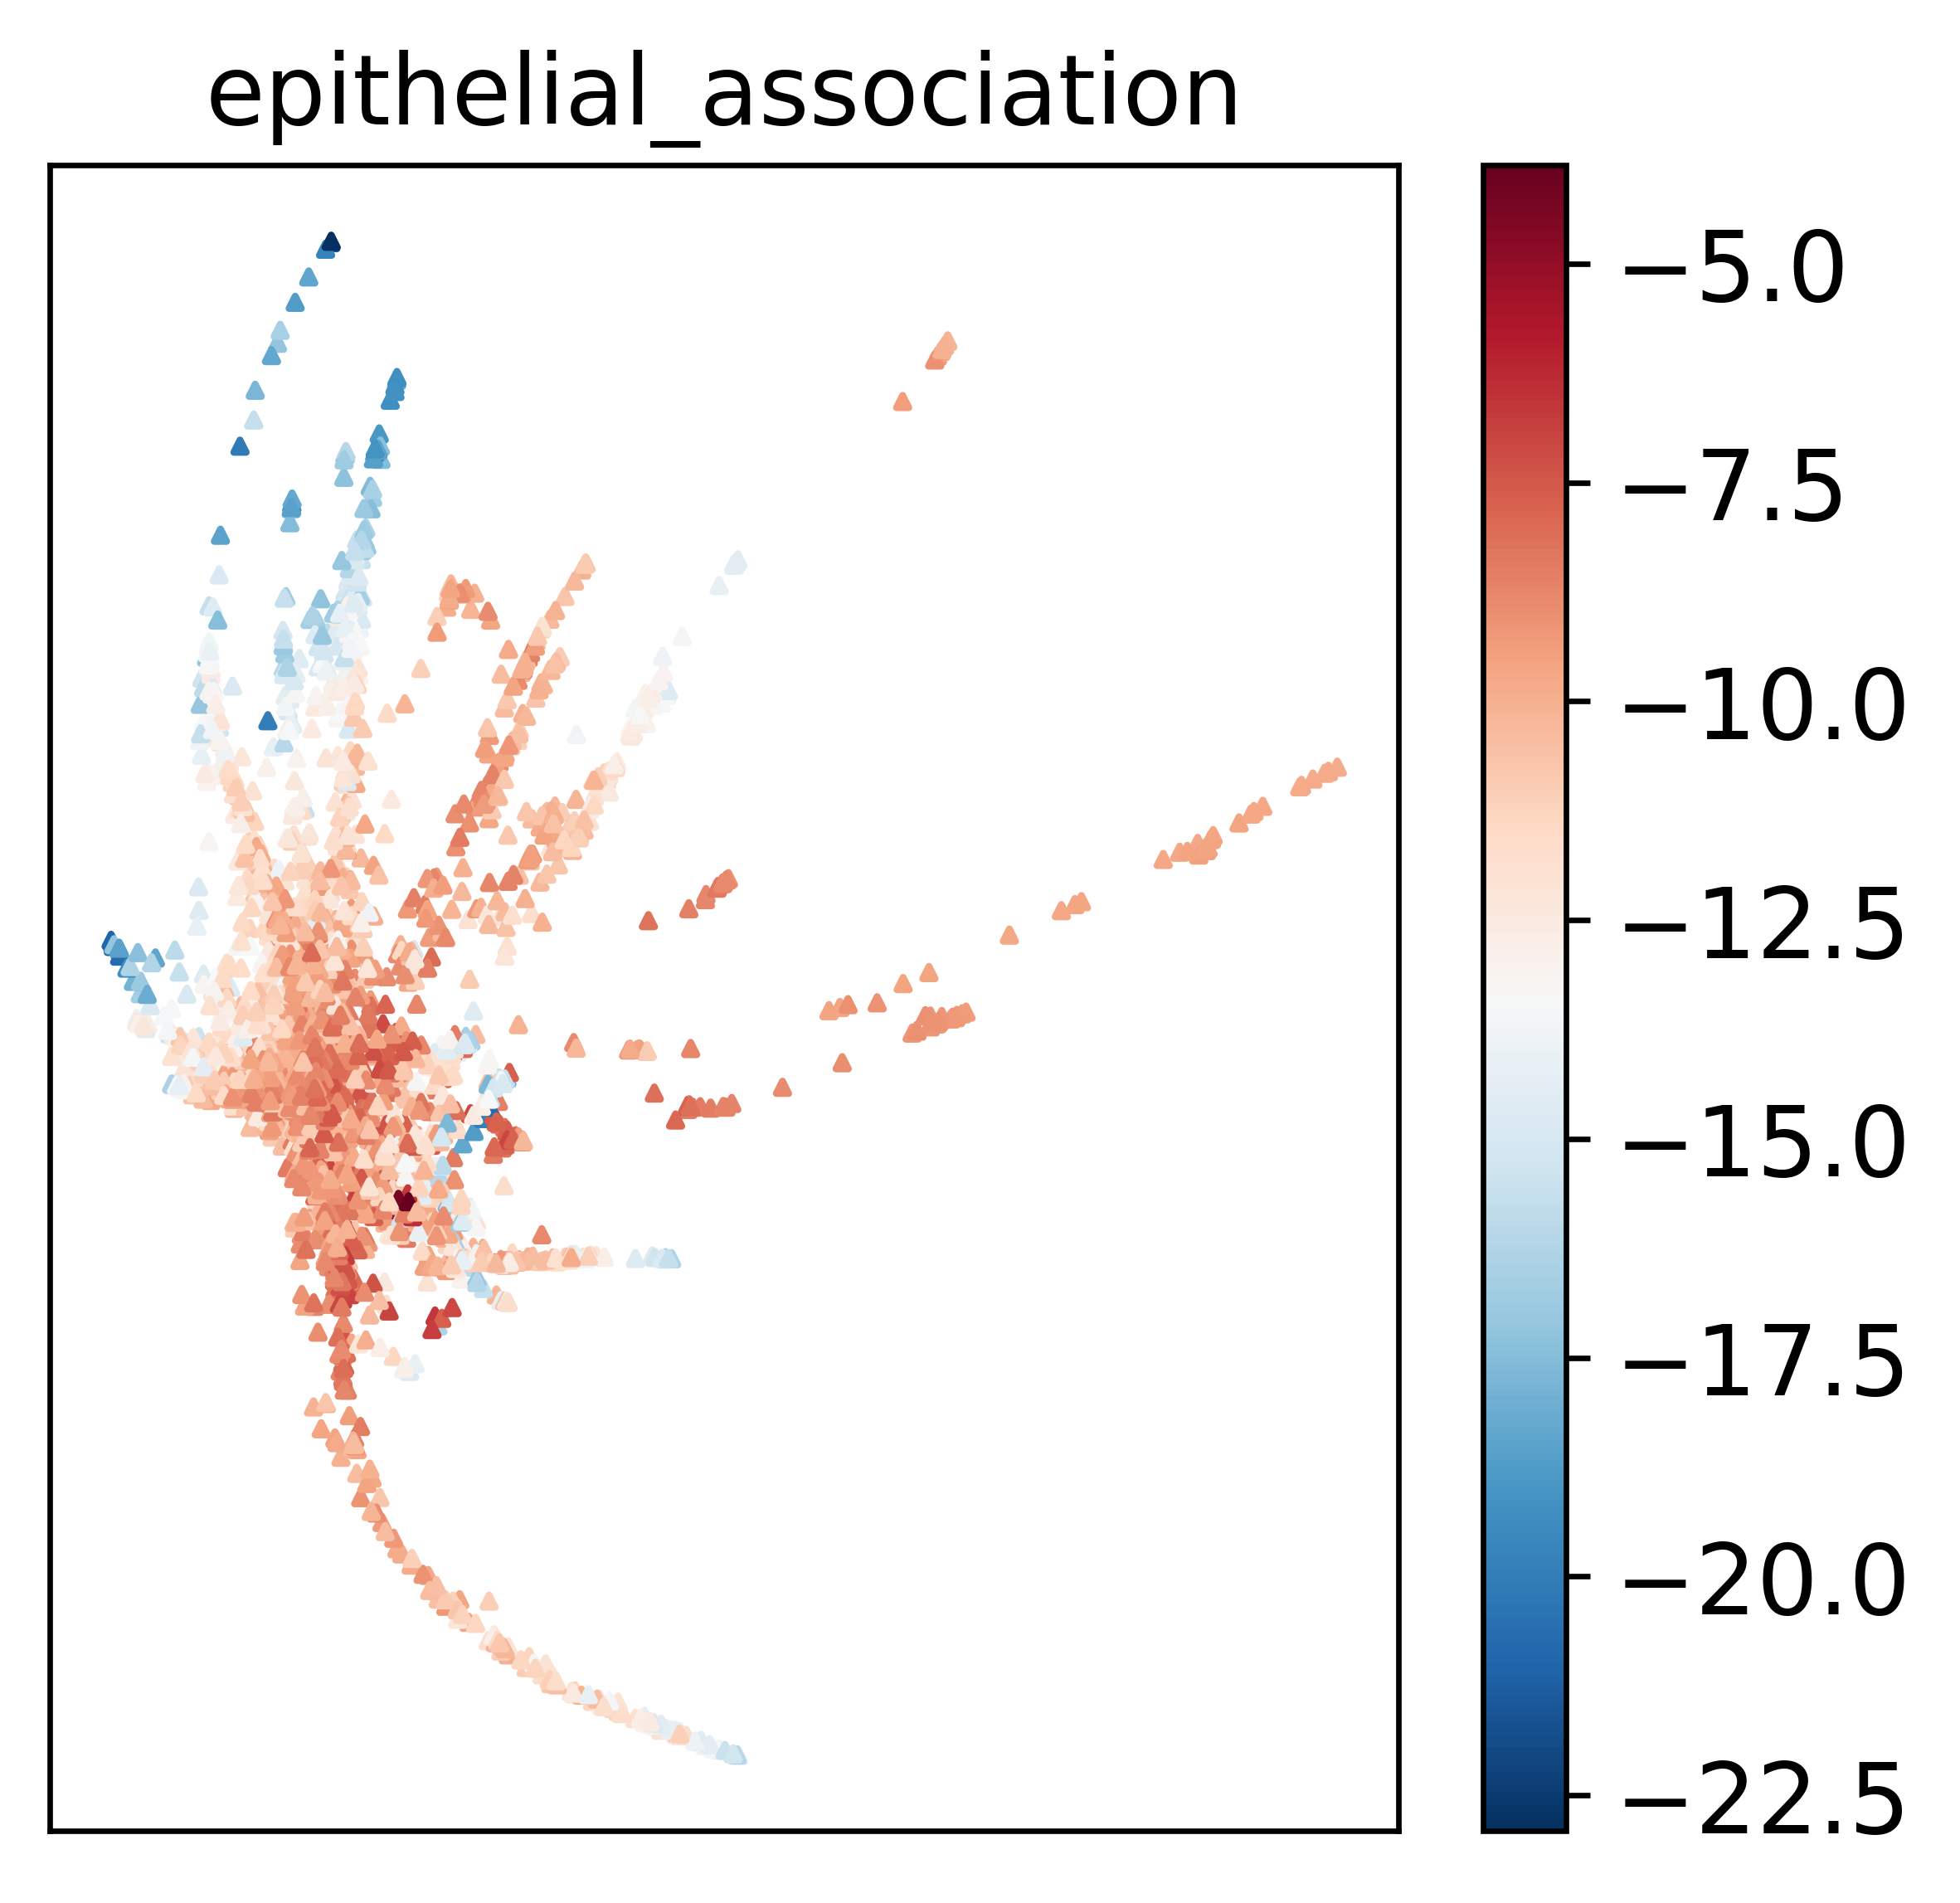

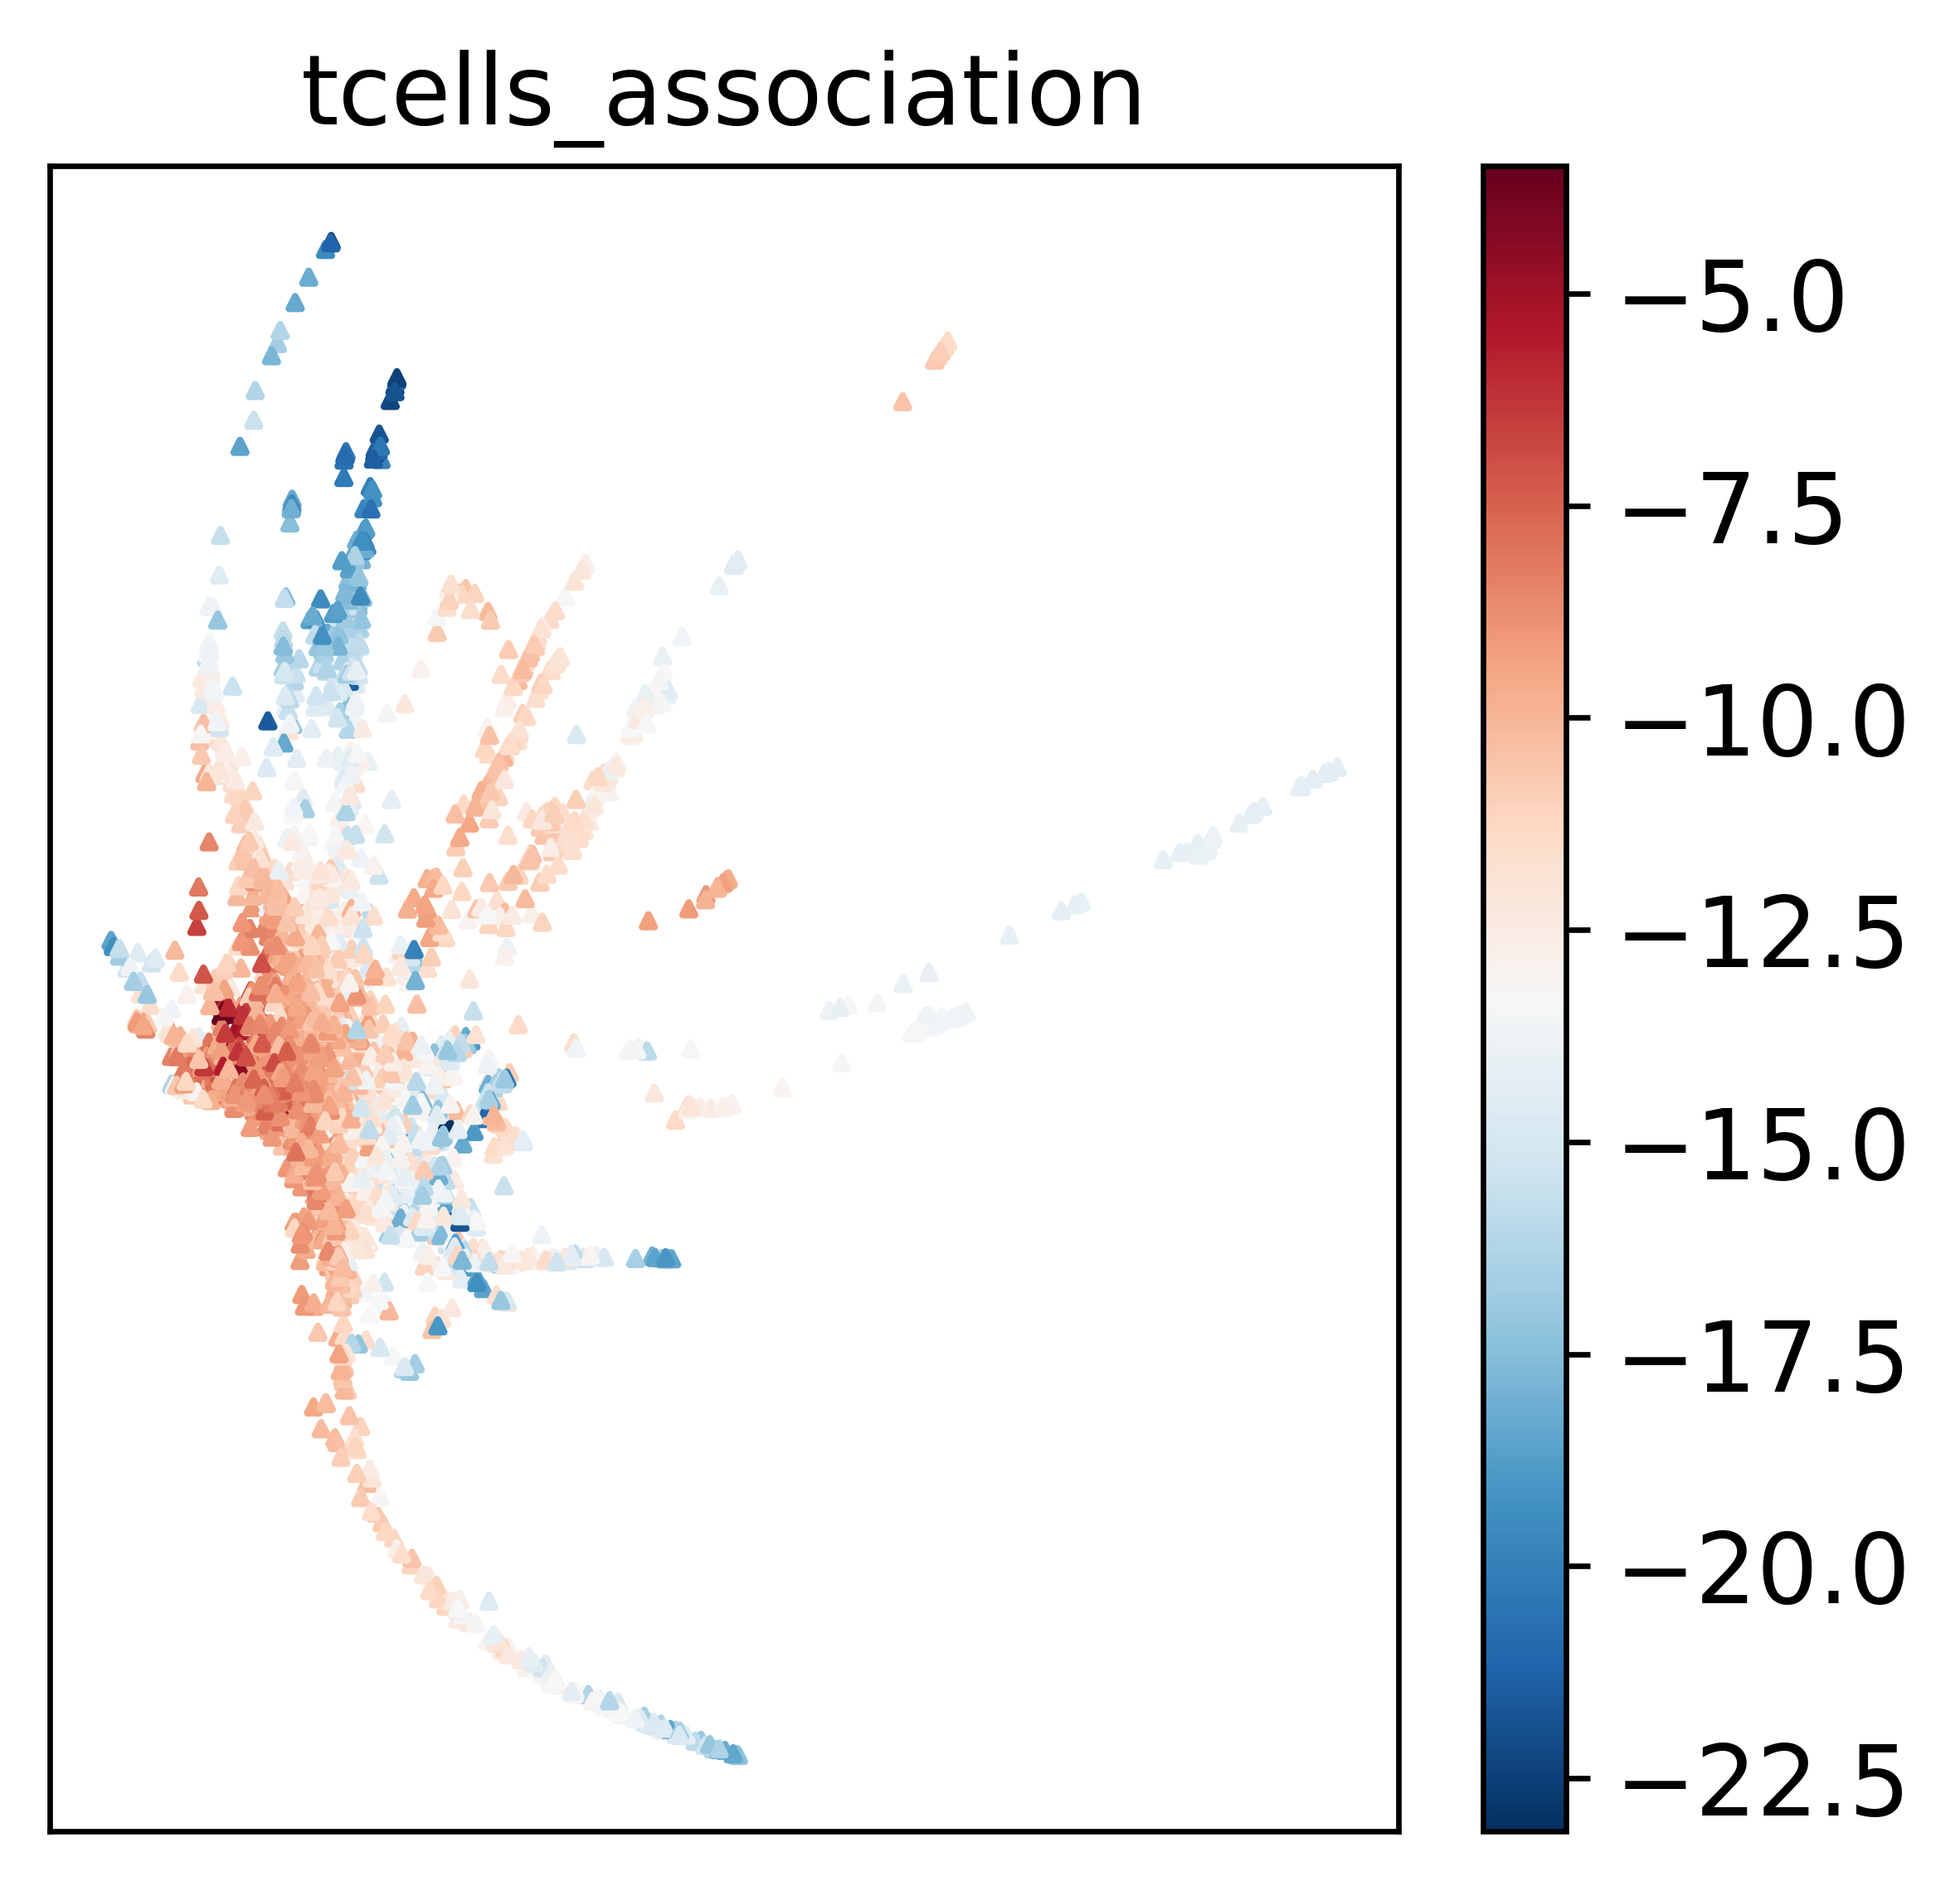

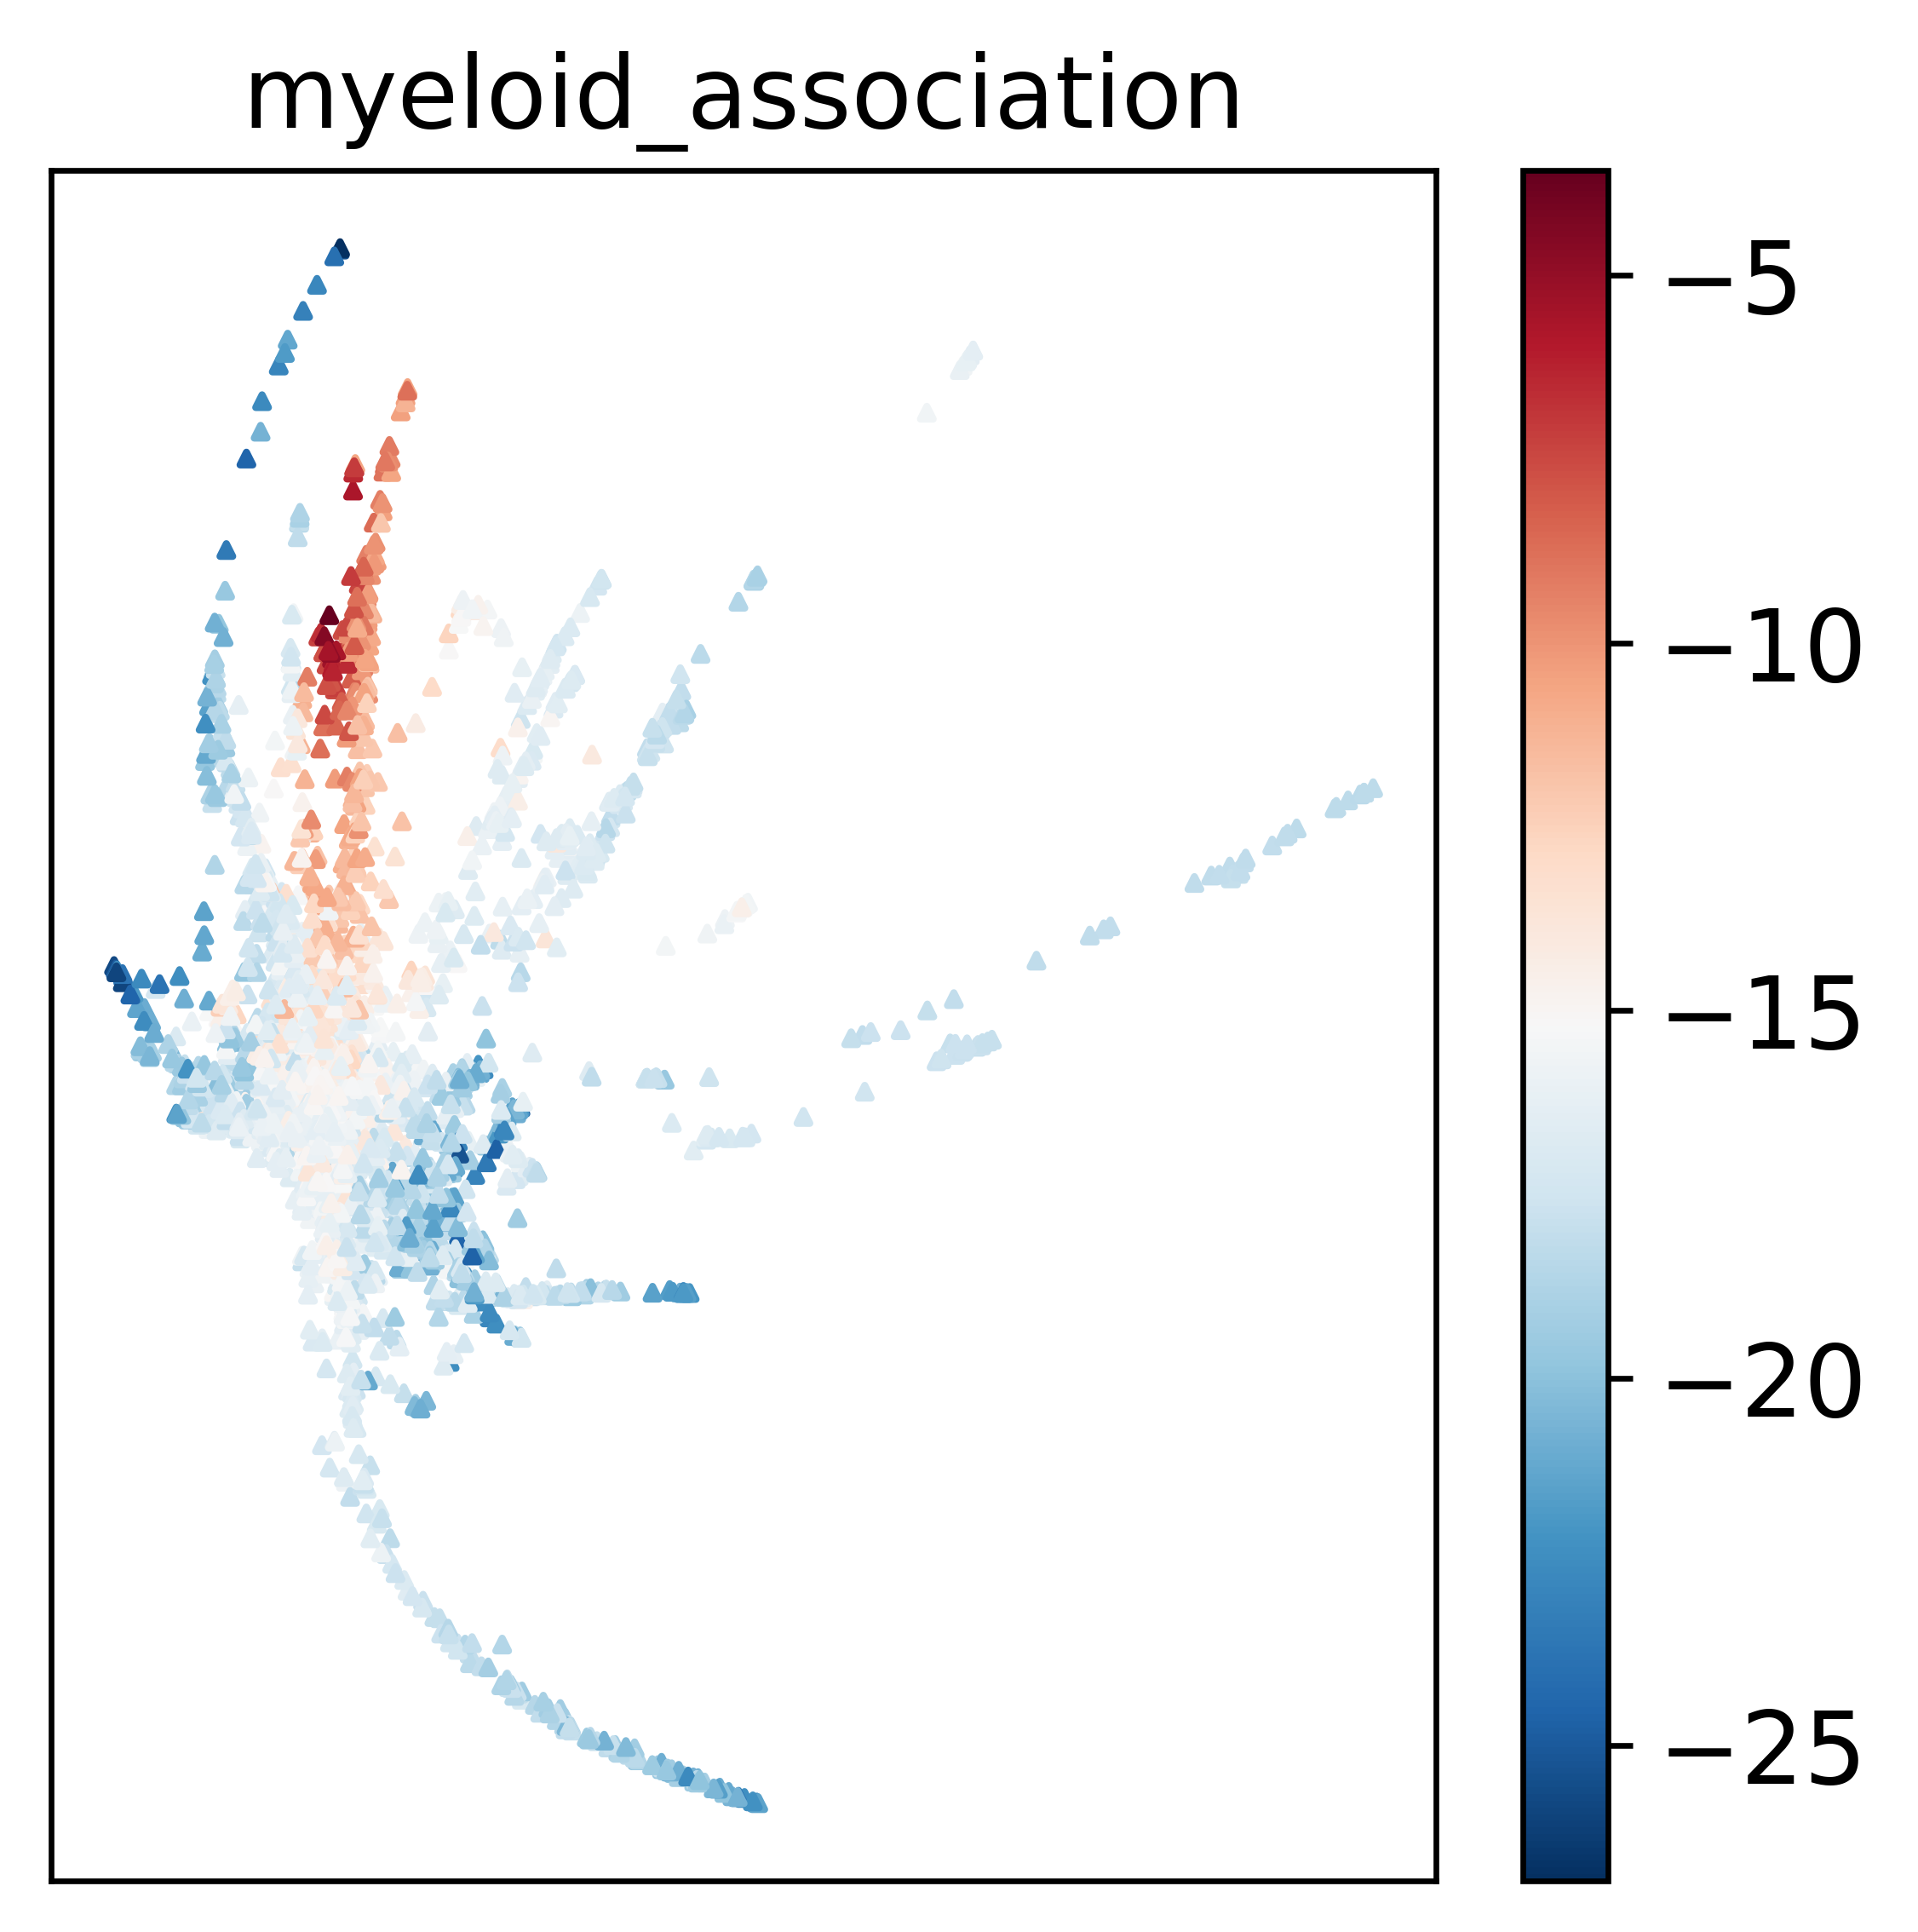

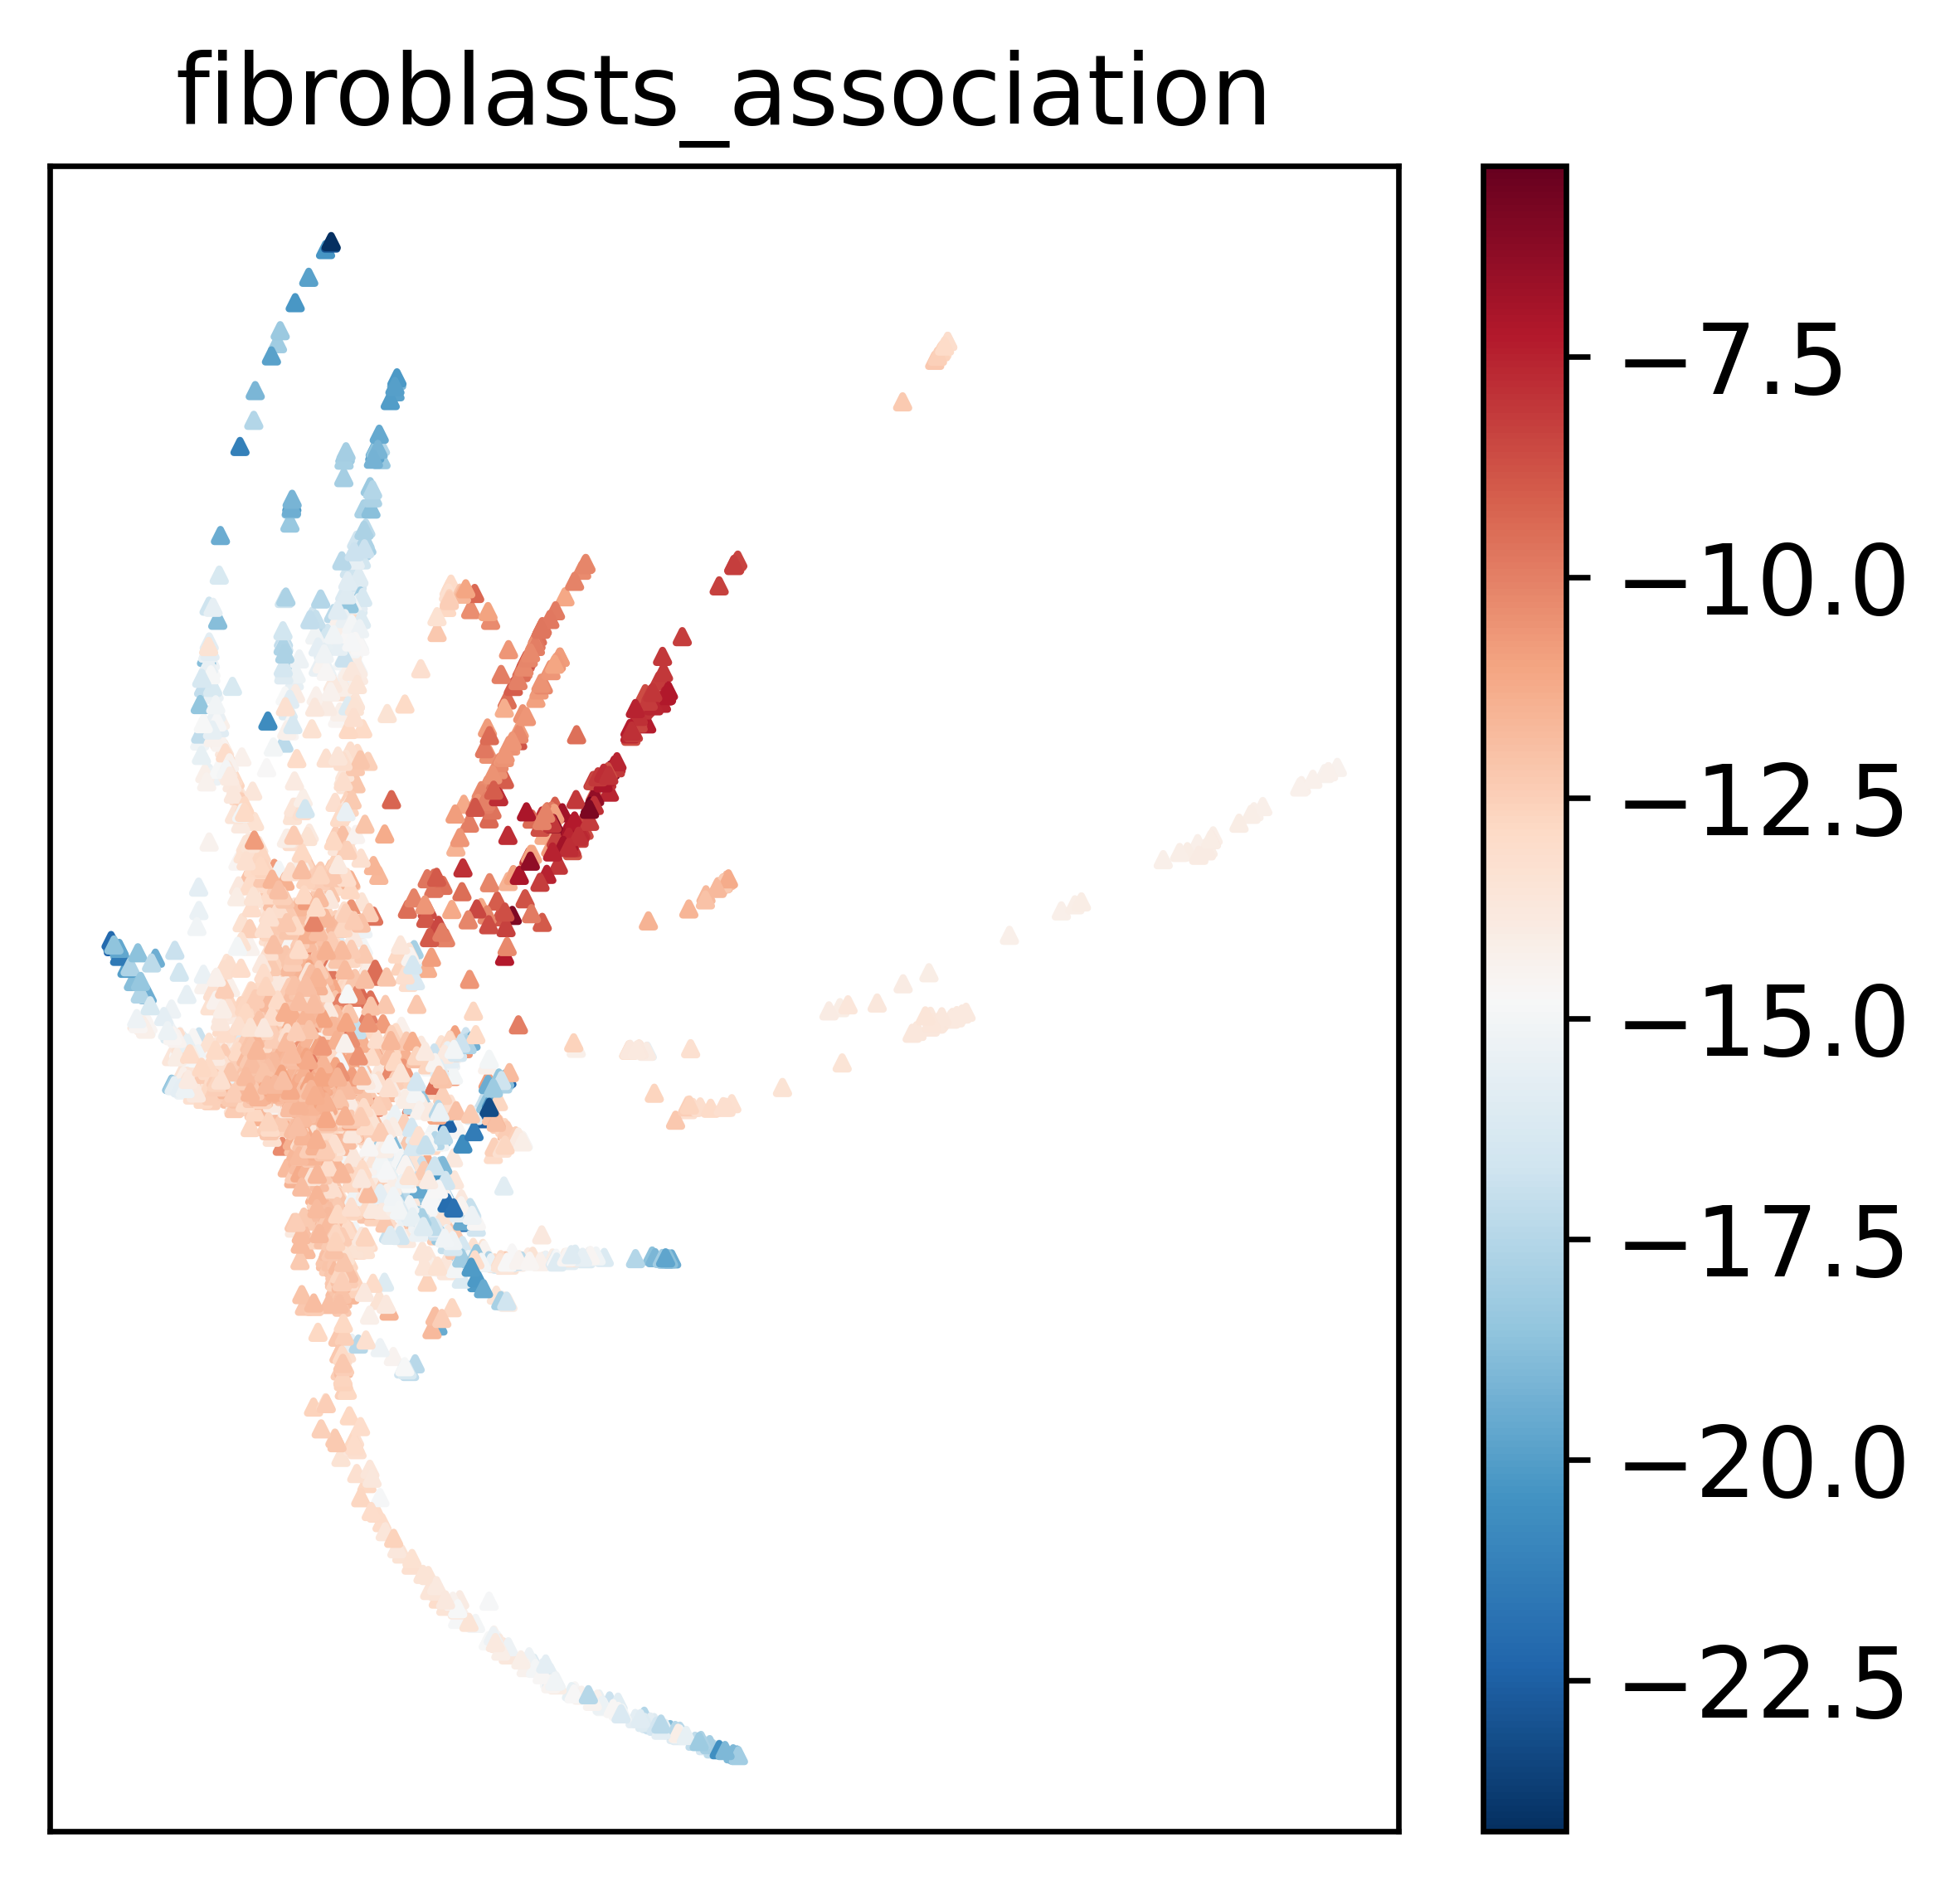

In [12]:
for cell_type in ['epithelial_association', 'tcells_association', 'myeloid_association', 'fibroblasts_association']:
    scprep.plot.scatter2d(gene_phate, c=res[cell_type], title=cell_type, cmap='RdBu_r', ticks=None, 
                          filename=f'figures/{cell_type}.png', dpi=200, marker='^')

In [8]:
marker_genes = []
for cell_type in ['epithelial_association', 'fibroblasts_association', 'myeloid_association', 'tcells_association', ]:
    marker_genes.extend(hvgs[np.argsort(res[cell_type])][:10].tolist())

In [9]:
adata.var.index = adata.var['full_name']

In [10]:
scanpy.set_figure_params(dpi=300, dpi_save=500)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


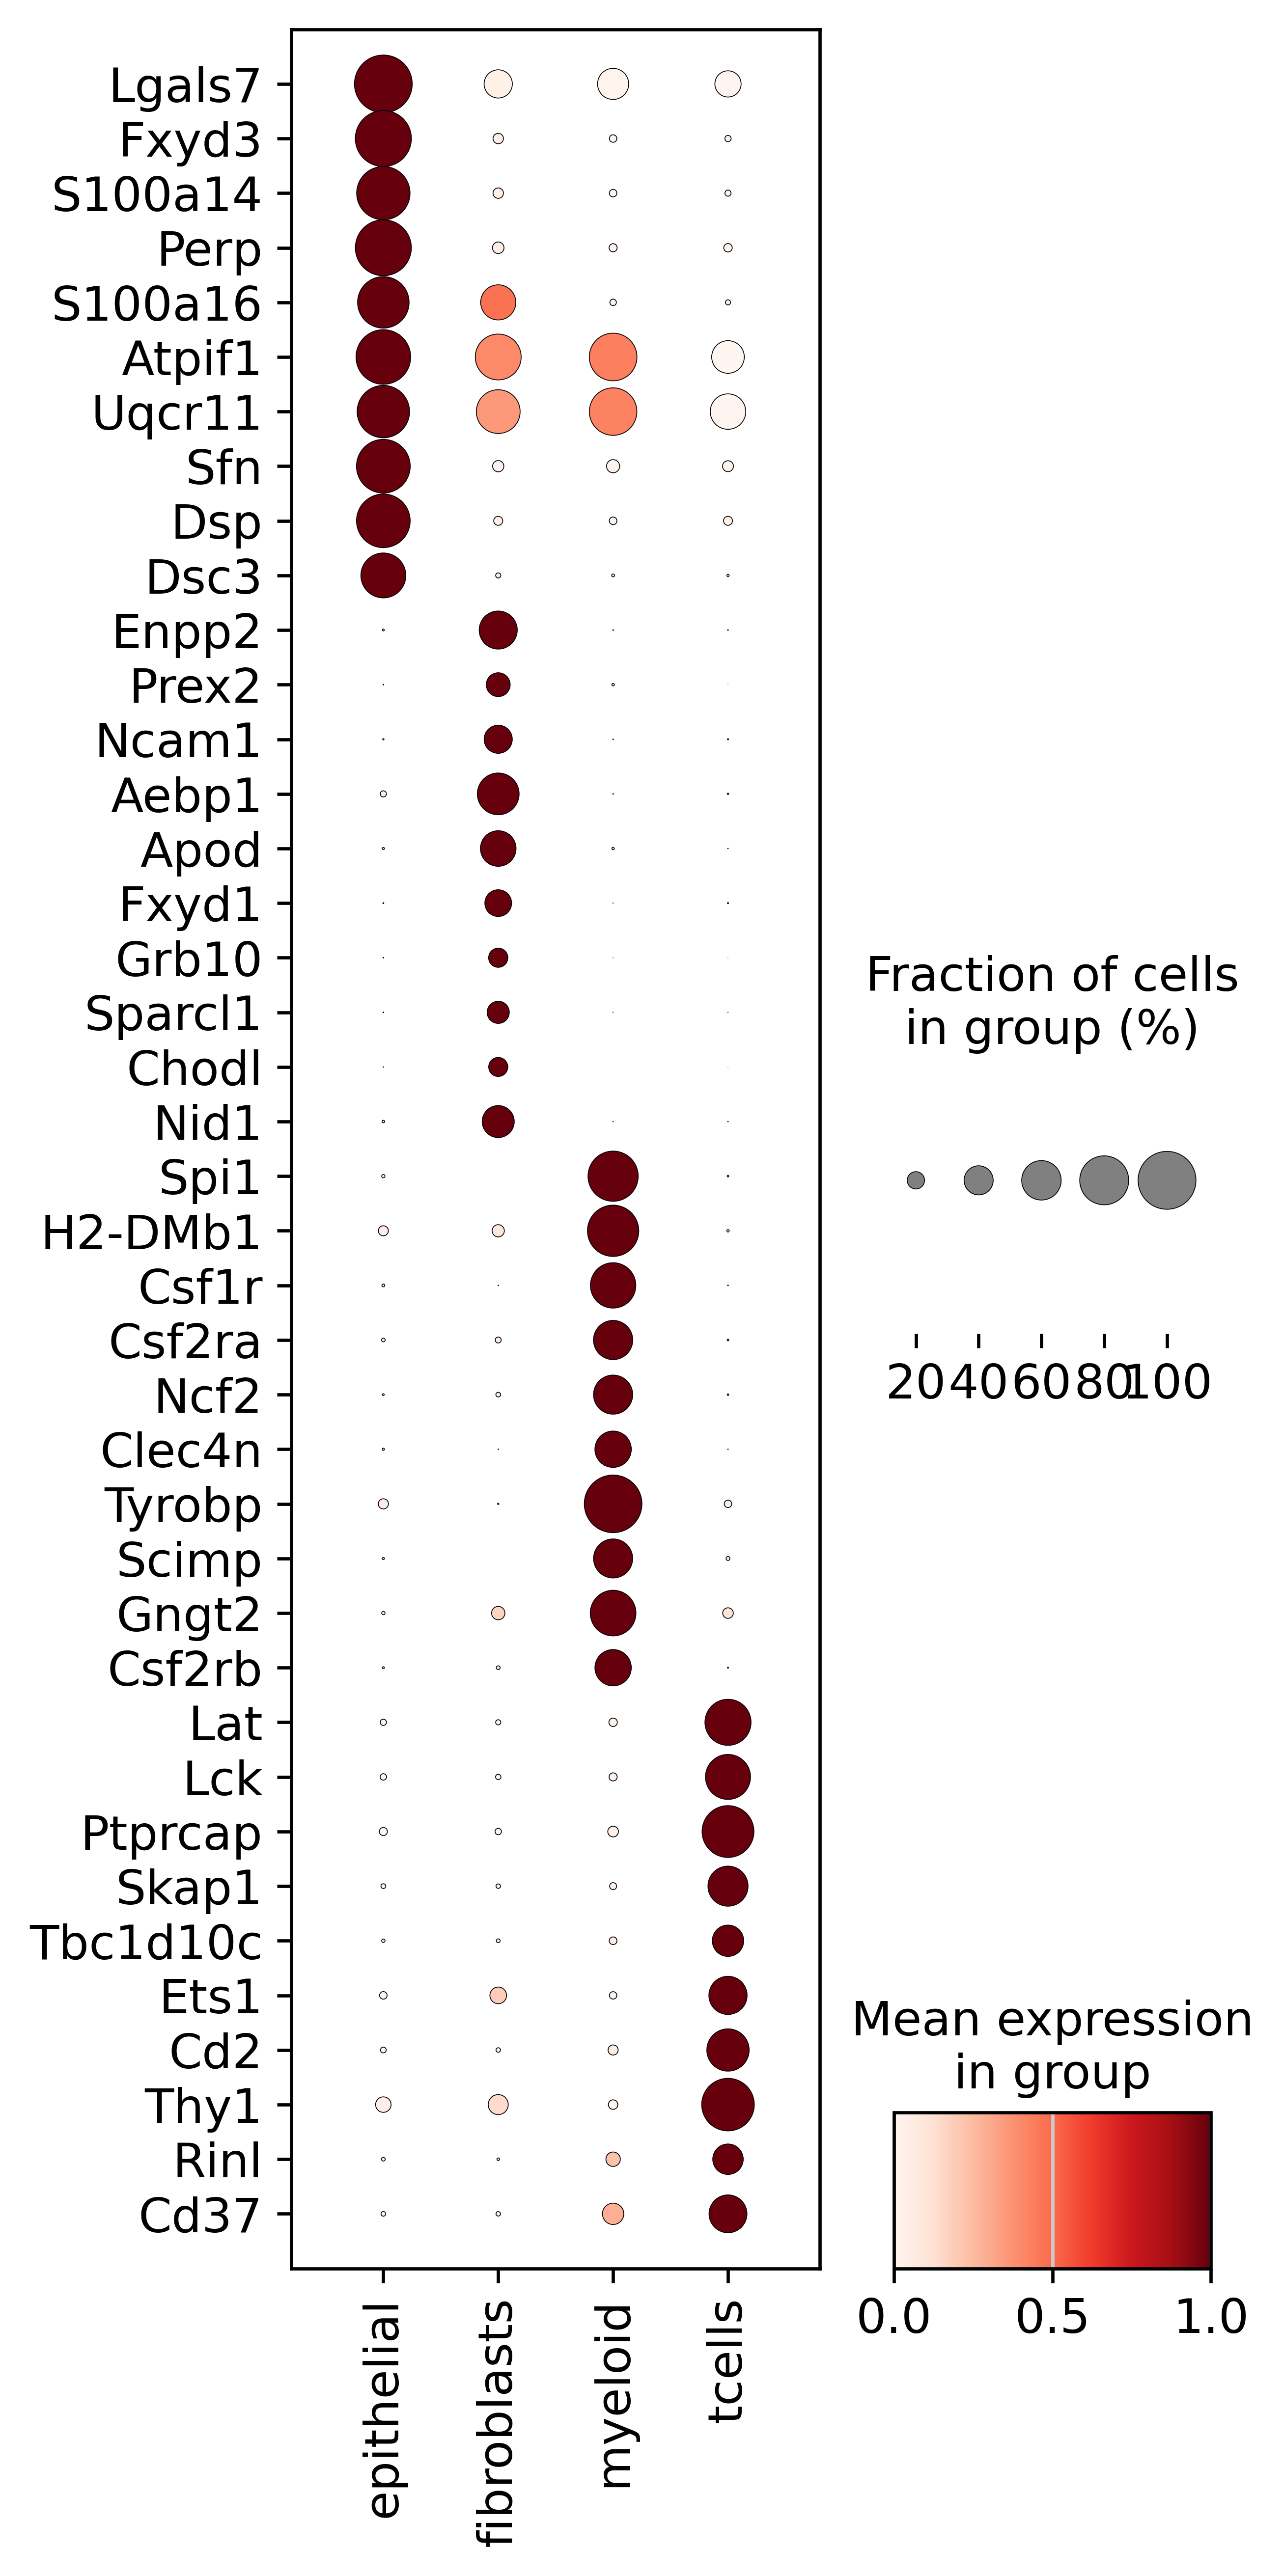

In [11]:
scanpy.pl.dotplot(adata, var_names=marker_genes, groupby='cell_types', cmap='Reds', gene_symbols='symbol', swap_axes=True,
                 figsize=(4,10), expression_cutoff=1e-1, standard_scale='var', save='cell_type_association.png')